# BIOS470/570 Lecture 8

## Last time we covered:
* ### Missing data, duplicated data, and string operations
* ### merging multiple data sets with pandas

## Today we will cover:
* ### Clustering data 
* ### seaborn plotting package
* ### Gene ontology

### Import the usual packages

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### We will need three new packages today: seaborn, scipy, and gget. 
* #### seaborn is a plotting package built on top of matplotlib for stastical plotting. It allows for making complex plots with high level functions and is built to run on pandas dataframes. 
* #### scipy has packages for scientific computing. It contains a clustering package that we will use today. 
* #### gget is a new package used for querying a variety of biological databases directly from  python code. We will use it for gene ontology.
### The install commands for these are:
* #### conda install scipy
* #### conda install seaborn
* #### conda install -c bioconda gget

In the last command, the -c flag is for channel. The bioconda channel contains many bio-specific python packages. 

In [25]:
import seaborn as sns
import scipy

In [68]:
data_human = pd.read_excel('data/GSE137492_SupplementaryTable1.xlsx')
data_frog = pd.read_csv('data/xen_uic_hik_stage8_13_30min.tsv',delimiter='\t')
data_frog

,Gene,UIC_1,UIC_2,UIC_3,UIC_4,UIC_5,UIC_6,UIC_7,UIC_8,UIC_9,...,hiK_4,hiK_5,hiK_6,hiK_7,hiK_8,hiK_9,hiK_10,hiK_11,hiK_12,hiK_13
0,ERCC-00002,31214.576742,20746.843327,15820.337040,20838.927449,25080.934940,29831.229808,24861.131004,36816.482281,34312.248268,...,28184.968376,19688.475156,29938.310266,28541.843106,30003.888946,23624.073849,29761.774428,22035.255266,26465.297048,21269.691751
1,ERCC-00003,437.926357,557.064559,866.145398,433.958134,818.379659,679.768702,500.984542,809.144548,406.137935,...,352.206012,492.214783,291.434743,808.480389,237.734226,301.385919,237.534037,460.571027,306.159383,482.196969
2,ERCC-00004,5806.778562,8623.257792,8237.850004,8178.254056,10592.701113,9891.303195,8726.999262,12260.089501,11976.640426,...,13608.644991,16566.958407,9654.972170,12133.451188,14265.971389,12083.938179,8698.798098,12887.553996,12818.688844,12838.119950
3,ERCC-00009,1088.855183,863.714979,671.476023,802.093203,1035.790118,1219.818702,1046.460250,1396.138819,1639.751660,...,1517.123939,991.687522,1460.126178,1427.445192,1620.857266,1145.198951,1564.682693,1073.023014,1322.888859,1045.675688
4,ERCC-00012,0.000000,0.379541,0.452181,0.738587,0.000000,0.343011,0.000000,0.000000,0.306320,...,0.000000,0.347242,0.381030,0.000000,0.245311,0.000000,0.000000,0.245311,0.615651,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34279,gene9998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.201554,0.000000
34280,gene9999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
34281,gene999|pigc,61.549566,91.810776,92.165413,65.268938,52.588501,33.829544,20.088473,9.646476,3.793154,...,108.464857,61.554529,40.733655,25.499081,14.261506,7.053554,7.076894,3.491820,3.906363,3.400443
34282,gene99|pagr1,118.843645,92.368324,87.064401,82.688666,99.880389,101.344282,86.835663,108.325443,93.598130,...,141.626022,153.652799,148.496698,116.247660,93.938793,86.450597,73.302971,73.243916,64.223707,65.597644


In [69]:
data_human.dropna(inplace=True)
# for human data
data_human.index = data_human.loc[:,"genes"]
data_human.drop(["genes"],axis = "columns", inplace = True)
ensIds = data_human.loc[:,"geneIds"]
data_human.drop("geneIds",axis = "columns", inplace = True)

#for frog data
data_frog.index = data_frog.loc[:,"Gene"]
data_frog.drop("Gene",axis = "columns", inplace = True)

### When dealing with large datasets, it is often useful to reduce them to the variables of interest to make the size of the dataset smaller and the processing faster. It can also focus attention on relevant features of the dataset. 

### One of the simplest things is to remove genes with low or no experession in all conditions:


In [70]:
data = data_frog
expressed = data.max(axis = 1) > 1
data = data.loc[expressed]
data

,UIC_1,UIC_2,UIC_3,UIC_4,UIC_5,UIC_6,UIC_7,UIC_8,UIC_9,UIC_10,...,hiK_4,hiK_5,hiK_6,hiK_7,hiK_8,hiK_9,hiK_10,hiK_11,hiK_12,hiK_13
Gene,,,,,,,,,,,,,,,,,,,,,
ERCC-00002,31214.576742,20746.843327,15820.337040,20838.927449,25080.934940,29831.229808,24861.131004,36816.482281,34312.248268,20359.539263,...,28184.968376,19688.475156,29938.310266,28541.843106,30003.888946,23624.073849,29761.774428,22035.255266,26465.297048,21269.691751
ERCC-00003,437.926357,557.064559,866.145398,433.958134,818.379659,679.768702,500.984542,809.144548,406.137935,465.824852,...,352.206012,492.214783,291.434743,808.480389,237.734226,301.385919,237.534037,460.571027,306.159383,482.196969
ERCC-00004,5806.778562,8623.257792,8237.850004,8178.254056,10592.701113,9891.303195,8726.999262,12260.089501,11976.640426,11454.103369,...,13608.644991,16566.958407,9654.972170,12133.451188,14265.971389,12083.938179,8698.798098,12887.553996,12818.688844,12838.119950
ERCC-00009,1088.855183,863.714979,671.476023,802.093203,1035.790118,1219.818702,1046.460250,1396.138819,1639.751660,653.677172,...,1517.123939,991.687522,1460.126178,1427.445192,1620.857266,1145.198951,1564.682693,1073.023014,1322.888859,1045.675688
ERCC-00013,1.595066,2.714069,2.124681,3.556401,5.598264,5.408346,0.000000,1.394690,6.920763,9.474534,...,7.717516,4.473985,0.000000,5.343649,2.166252,1.046044,1.159123,4.255901,5.126609,2.498846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene9993,0.000000,0.000000,0.000000,0.000000,0.615317,0.000000,0.000000,0.660713,0.638031,0.432219,...,0.394240,0.000000,0.000000,0.000000,0.000000,0.000000,0.394240,0.000000,0.000000,0.000000
gene9994,0.411977,0.143414,0.166301,0.073697,0.234250,0.477723,1.684802,4.581279,4.700683,5.612203,...,0.132233,0.000000,0.675504,4.458419,3.713165,4.380137,5.278313,7.526685,5.823007,8.682288
gene9996,0.000000,1.089618,1.858241,0.000000,0.000000,0.000000,0.000000,0.632419,0.833701,0.000000,...,1.348054,2.442547,0.000000,3.912911,1.004170,0.734557,0.927359,0.773215,0.927359,2.685826


### A second commonly used step is to restrict attention to the variable genes, that is genes that change expression between different conditions in the dataset. Genes that are expressed approximately the same in all conditions are probably not of interest for the conditions being studied. One metric for this is to compare the standard deviation with the mean. 

### Here, we implement a cutoff in this ratio:

In [72]:
variable = data.std(axis = 1)/data.mean(axis = 1) > 1.5
data = data.loc[variable]
data

,UIC_1,UIC_2,UIC_3,UIC_4,UIC_5,UIC_6,UIC_7,UIC_8,UIC_9,UIC_10,...,hiK_4,hiK_5,hiK_6,hiK_7,hiK_8,hiK_9,hiK_10,hiK_11,hiK_12,hiK_13
Gene,,,,,,,,,,,,,,,,,,,,,
ERCC-00081,1.463471,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.362920,0.786405,...,0.000000,1.581468,0.0,0.739541,0.000000,0.000000,0.00000,0.575268,0.706771,0.000000
ERCC-00086,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,3.932843,0.000000,0.000000
ERCC-00104,0.000000,0.000000,0.651909,0.0,0.000000,0.000000,0.270371,0.000000,0.462809,0.000000,...,0.000000,0.000000,0.0,0.615195,0.464825,0.000000,0.00000,0.000000,0.000000,0.000000
ERCC-00123,0.000000,1.149186,0.679833,0.0,1.380665,0.000000,0.560652,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.839056,0.000000,0.000000,0.00000,1.439658,0.630599,1.104586
ERCC-00134,0.000000,0.000000,0.000000,0.0,1.961959,0.000000,4.299303,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,5.700133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene9976,0.000000,0.000000,0.000000,0.0,1.402592,0.000000,0.000000,0.000000,0.000000,0.423590,...,1.059703,2.358060,0.0,2.151050,0.000000,0.443603,0.00000,0.000000,0.000000,0.000000
gene9981,0.000000,0.000000,0.000000,0.0,5.976860,20.299485,21.078794,17.169367,5.976860,0.000000,...,6.877211,0.000000,0.0,3.500499,0.000000,5.617674,0.00000,0.000000,3.500499,0.000000
gene9984,0.000000,0.000000,0.000000,0.0,2.381620,1.345219,1.405731,2.361896,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,2.250417,0.000000,0.00000,0.000000,0.000000,0.000000


### Now we will perform a hierachical clustering of the data and visualize it using a heatmap with the tree overlaid. 

### we can call the seaborn clustermap function to do this. Behind scenes it is using scipy's hierachical clustering functions to do the clustering. As before we look at log2(data+1) for better visualization.

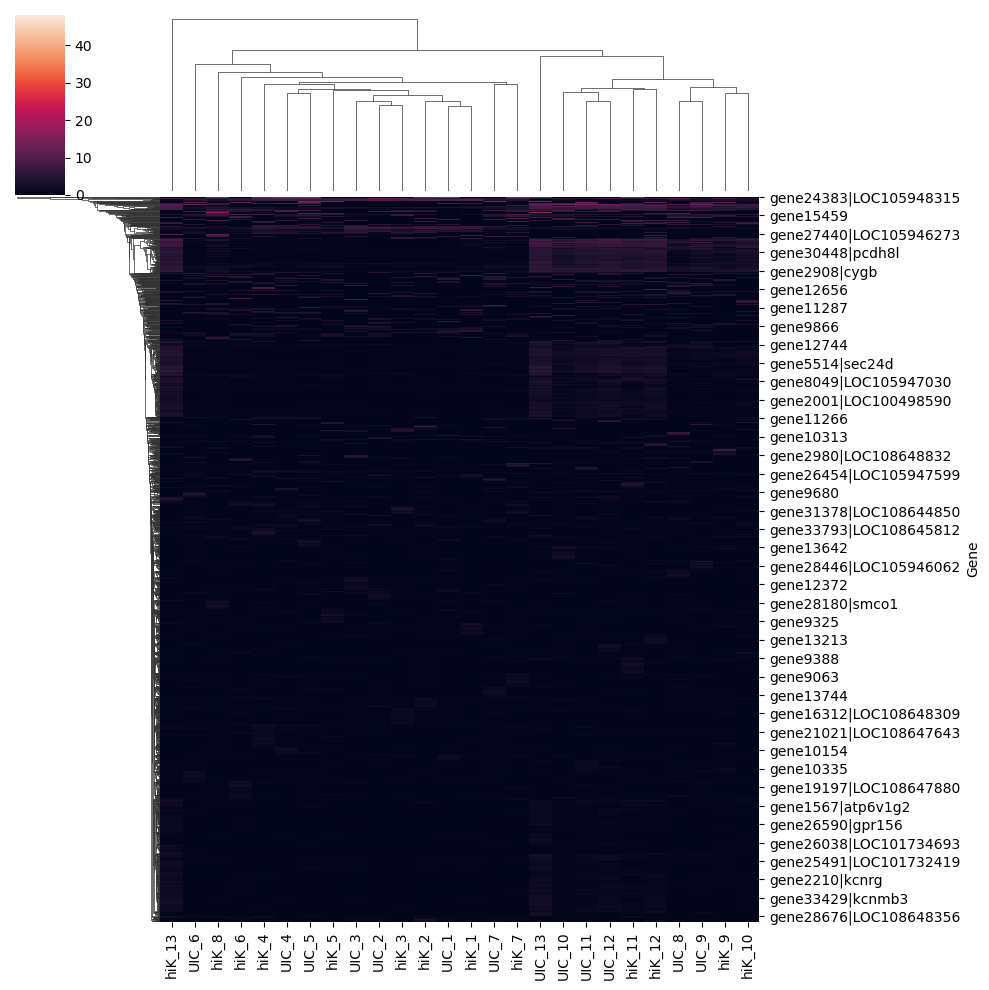

In [73]:
cg = sns.clustermap(np.log2(data+1))


### That could be more informative. Too much of the genes fall in the dark part of the colormap. We can use the vmax parameter to set the top of the colormap (there is also an analagous vmin parameter). 

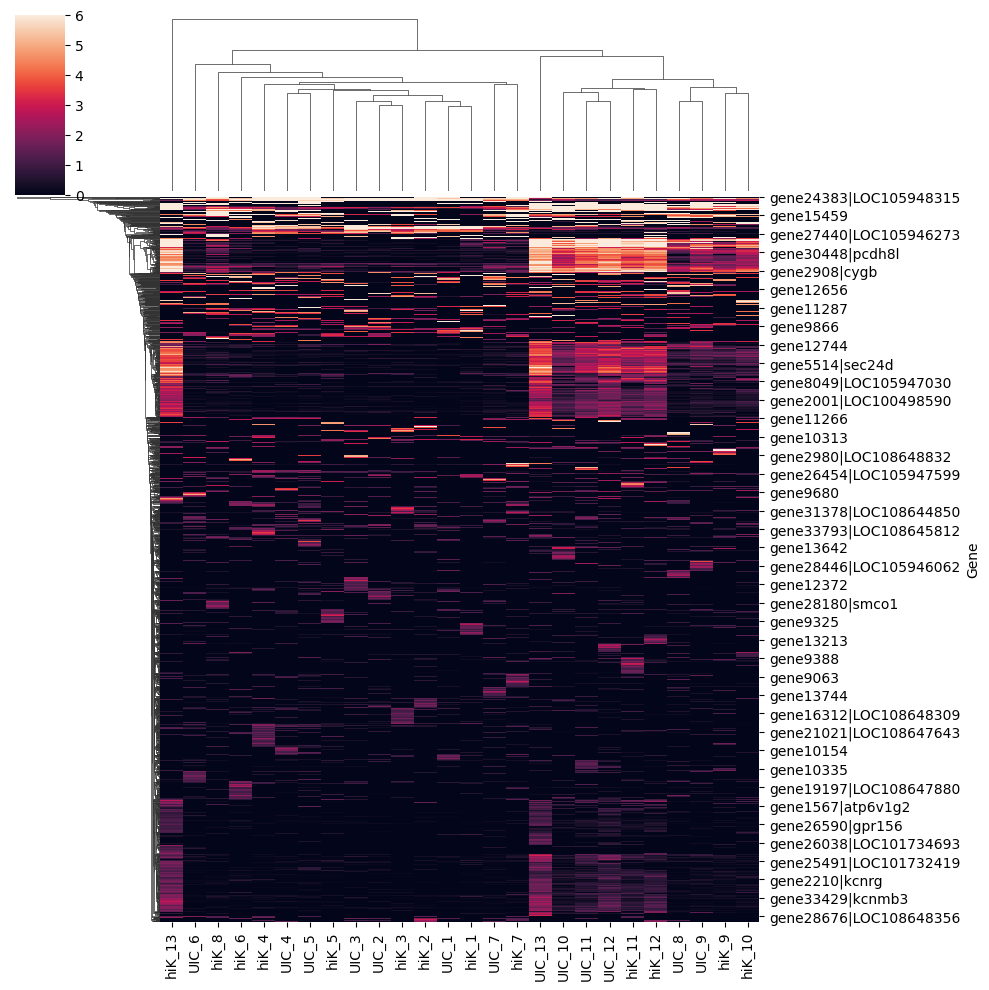

In [74]:
cg = sns.clustermap(np.log2(data+1), vmax = 6)

### Notice that seaborn has handled all the labelling for us based on the index and columns of the data frame. 

### We can also change the colormap to change the colors for the visualization. seaborn has lots of useful built in colormaps:

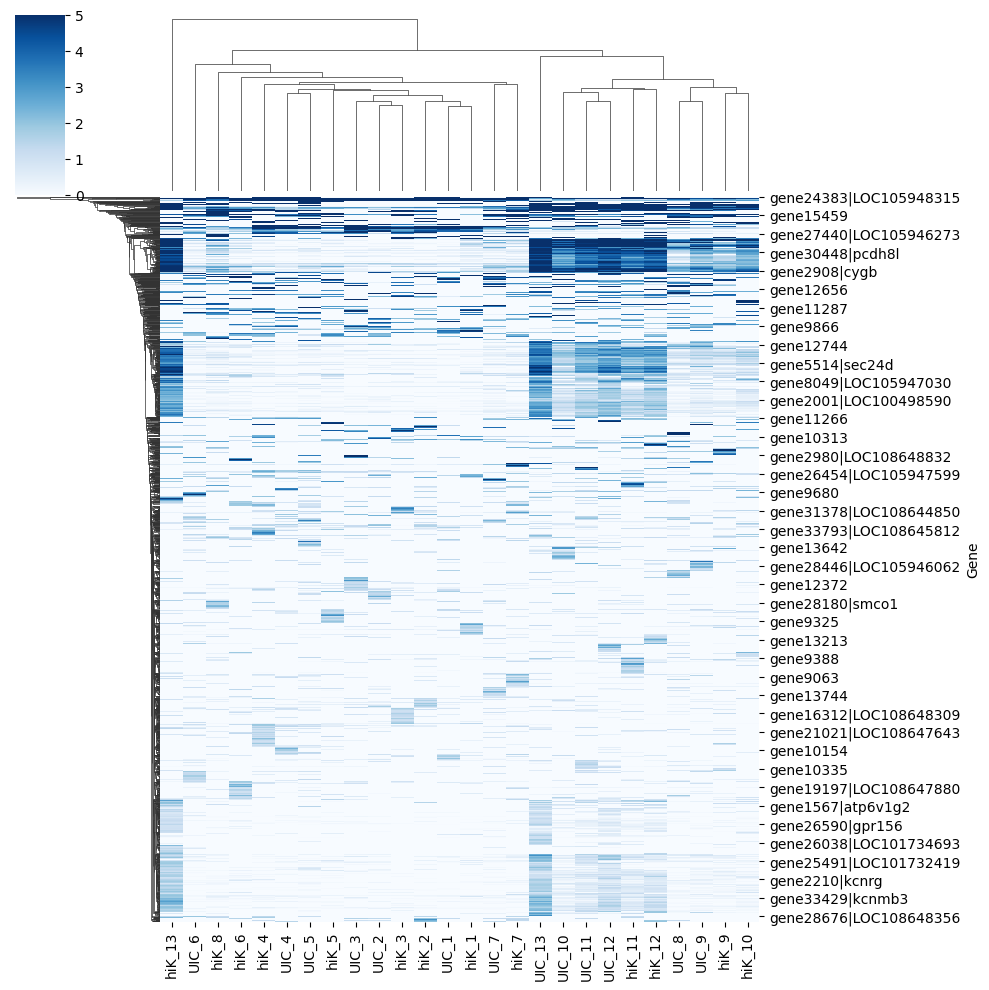

In [76]:
cg = sns.clustermap(np.log2(data+1),vmax = 5, cmap = "Blues")


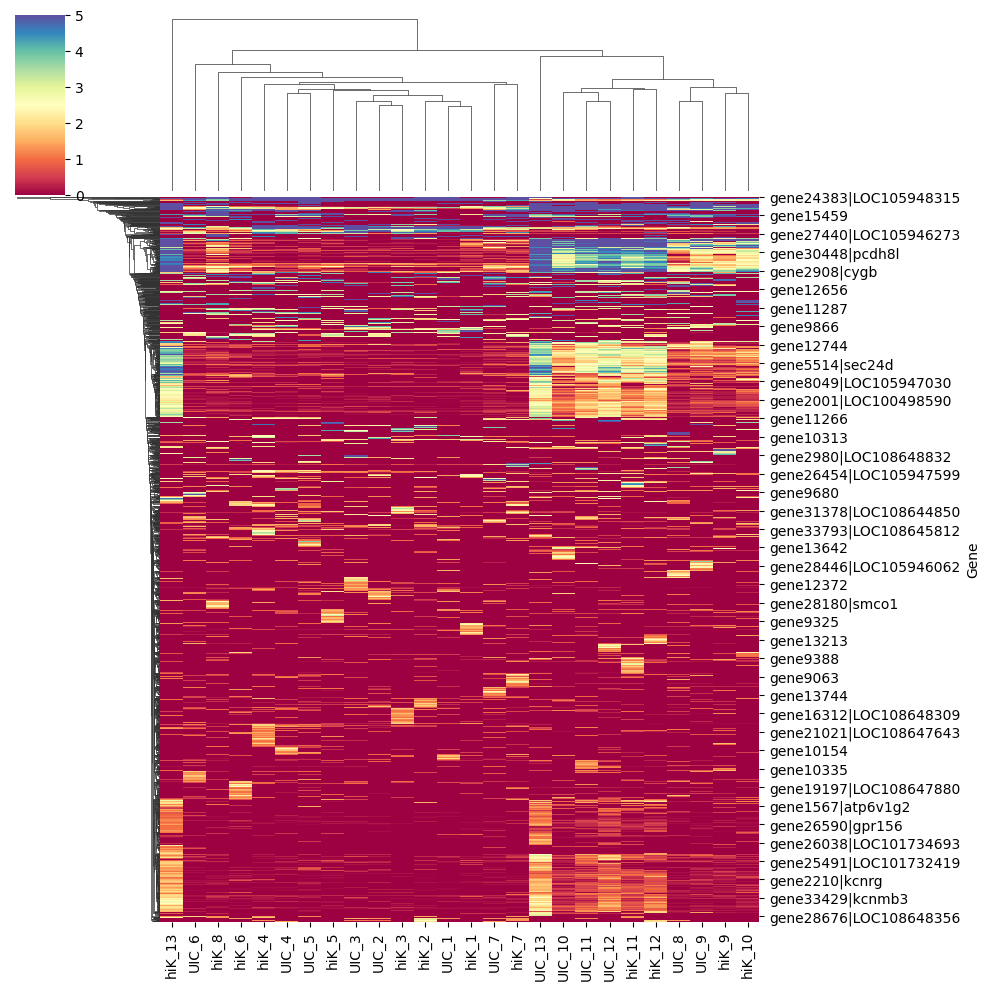

In [77]:
cg = sns.clustermap(np.log2(data+1),vmax = 5, cmap = "Spectral")

### There are lots of options for color in seaborn. See [here](https://seaborn.pydata.org/tutorial/color_palettes.html) for an in depth discussion of color palettes

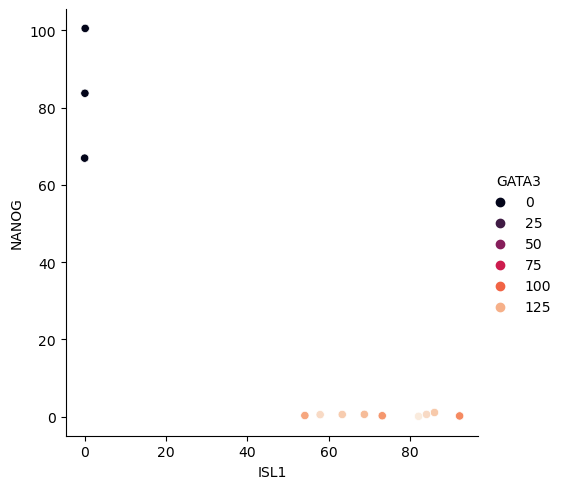

In [83]:
sns.relplot(x = data_human.loc["ISL1"], y = data_human.loc["NANOG"], hue = data_human.loc["GATA3"], palette = "rocket");

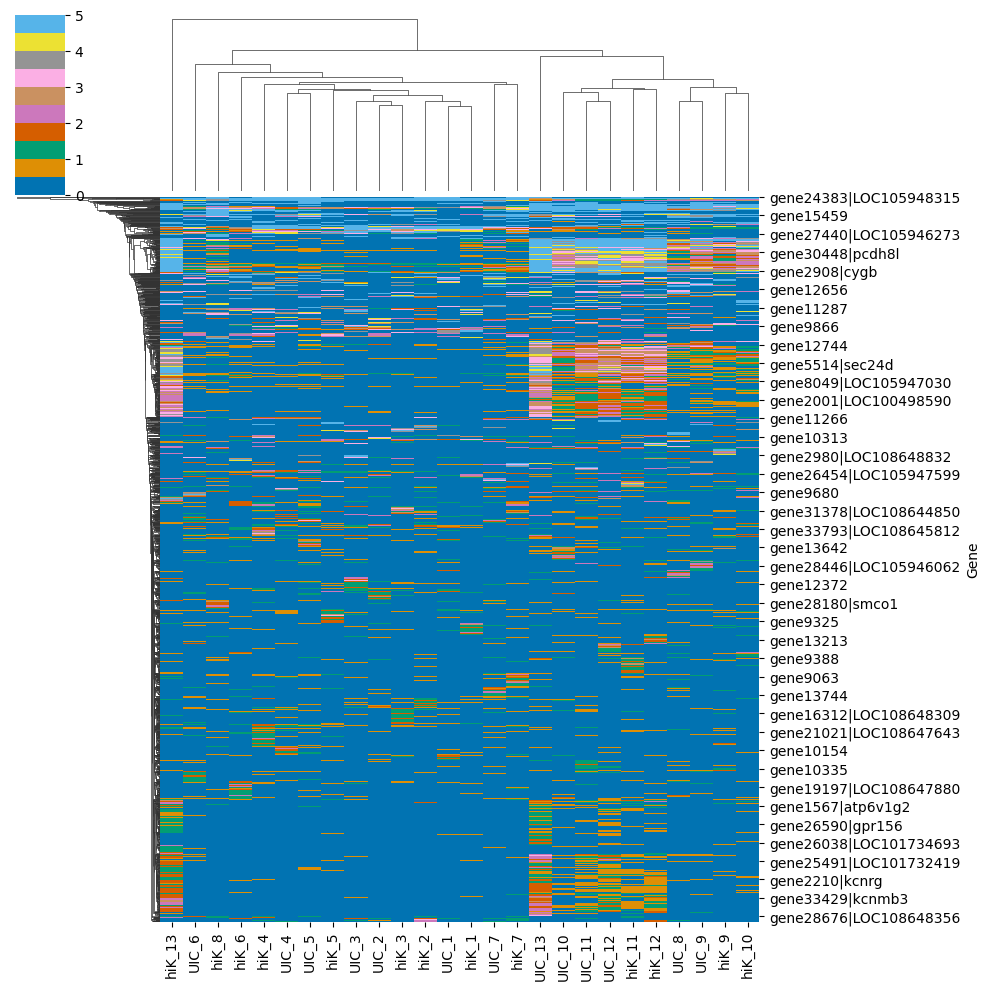

In [47]:
palette = sns.color_palette("colorblind", as_cmap = True)
cg = sns.clustermap(np.log2(data_reduced+1),vmax = 5, cmap = palette)